episode: 0/10, score: 24, e: 1.0
episode: 1/10, score: 13, e: 0.97
episode: 2/10, score: 8, e: 0.93
episode: 3/10, score: 36, e: 0.78
episode: 4/10, score: 96, e: 0.48
episode: 5/10, score: 9, e: 0.46
episode: 6/10, score: 9, e: 0.44
episode: 7/10, score: 74, e: 0.3
episode: 8/10, score: 29, e: 0.26
episode: 9/10, score: 11, e: 0.25


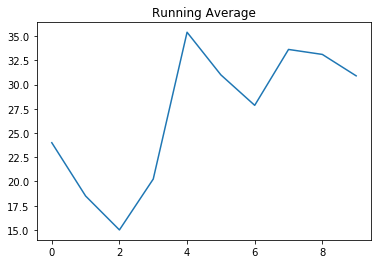

In [30]:
# -*- coding: utf-8 -*-
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

EPISODES = 100

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model_1 = self._build_model_1()
        self.model_2 = self._build_model_2()

    def _build_model_1(self):
        # Neural Net for Physics
        model_1 = Sequential()
        model_1.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model_1.add(Dense(24, activation='relu'))
        model_1.add(Dense(self.state_size*2, activation='linear'))
        model_1.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model_1
    
    def _build_model_2(self):
        # Neural Net for Rules
        model_2 = Sequential()
        model_2.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model_2.add(Dense(24, activation='relu'))
        model_2.add(Dense(1, activation='linear'))
        model_2.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model_2
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act_1(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # returns random action
        
        state_next = self.model_1.predict(state)
        #state_next_1 = self.model_1.predict(np.reshape(np.append(state,1),[1,5]))
        #print("state_next : {}" .format(state_next[0][0:8]))
        act_values0 = self.model_2.predict(np.reshape(state_next[0][0:4],[1,4]))
        act_values1 = self.model_2.predict(np.reshape(state_next[0][4:8],[1,4]))
        #if act_values0 > act_values1 : return 0
        #else return 1
        #print ("left : {} , right: {}" .format(act_values0,act_values1))
        return np.argmax([act_values0,act_values1])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            
            target_states = self.model_1.predict(state)
            #print("tar : {}" .format(target_states[0][0:9]))
            if action ==0:
                target_states[0][0:4] = next_state
            if action ==1:
                target_states[0][4:8] = next_state
            self.model_1.fit(state, target_states, epochs=1, verbose=0)
            #reward = reward if not done else -50
            #state_next_0 = self.model_1.predict(np.reshape(np.append(state,0),[1,5]))
            #state_next_1 = self.model_1.predict(np.reshape(np.append(state,1),[1,5]))
            #next_state0 = self.model_1.predict(np.reshape(np.append(next_state,0),[1,5]))
            #next_state1 = self.model_1.predict(np.reshape(np.append(next_state,1),[1,5]))
            target = [reward]
            if not done:
                target = [(reward + self.gamma*np.amax(self.model_2.predict(next_state)))]
            #self.model_2.fit(state, [target], epochs=1, verbose=0)
            self.model_2.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)
        
    def plot_running_avg(self, totalrewards):
        N = len(totalrewards)
        running_avg = np.empty(N)
        for t in range(N):
            running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
        plt.plot(running_avg)
        plt.title("Running Average")
        plt.show()


if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    # agent.load("./save/cartpole-dqn.h5")
    done = False
    batch_size = 32
    episode_reward = []

    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        
        for time in range(500):
            # env.render()
            action = agent.act_1(state)
            #print("action : {} " .format(action))
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -50
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, time, agent.epsilon))
                episode_reward.append(time)
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
    agent.plot_running_avg(episode_reward)
        # if e % 10 == 0:
        #     agent.save("./save/cartpole-dqn.h5")